# Introduction to Machine Learning HW4

----

#### 姓名：王祥任
#### 學號：0616309

----


## Import Modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import urllib3
import copy
import sklearn as sk
import math
import random as rnd
from sklearn import datasets
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
import tensorflow as tf

## plot_confusion_matrix function taken from sklearn sample with some modification
> Reference : HW1 Sample Code

In [2]:
def plot_confusion_matrix(y_true, y_pred, classes,        
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(20, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

## Data Loading & Preprocessing


In [3]:
# Import Word2Vec
from gensim.models.word2vec import Word2Vec

# Data Loading
train = pd.read_json('train.json')
test = pd.read_json('test.json')

# Prepare Data for Word2Vec
train_ingredients = [d[0] for d in train.drop(['id', 'cuisine'], axis=1).values.tolist()]
test_ingredients = [d[0] for d in test.drop(['id'], axis=1).values.tolist()]

all_ingredients = []
for d in train_ingredients:
    all_ingredients.append(d)
for d in test_ingredients:
    all_ingredients.append(d)

# Prepare 
model = Word2Vec(all_ingredients, size=300, iter=20, min_count=1, workers=12)


In [4]:
train = pd.read_json('train.json')
train_set = []
for data in train.values.tolist():
    tmp = []
    tmp.append(data[1])
    gre_vec = np.array([0 for _ in range(300)])
    for gre in data[2]:
        gre_vec = np.add(gre_vec, np.array(model.wv[gre]))
    tmp.extend(gre_vec)
    train_set.append(tmp)
train_set = pd.DataFrame(train_set)

le = sk.preprocessing.LabelEncoder()
le.fit(train_set[0])

classes = le.classes_

train_set[0] = le.transform(train_set[0])
train_set

0         1         2         3         4         5         6    \
0        9 -2.044709 -4.018720  2.395507  2.439996 -2.279481  2.327987   
1       16 -3.879736  0.265346  0.435484 -0.133509 -1.777257  2.486038   
2       18  3.866721 -2.406342  3.019859  5.592268  0.576502  4.849381   
3       14  0.207400  0.836980 -0.702978 -0.347707  0.654110  0.182332   
4        3 -0.184935 -3.036445  2.845268  3.397919  0.532851  0.644099   
...    ...       ...       ...       ...       ...       ...       ...   
29769   11  1.993824 -5.791325  5.969348  5.675846 -0.149109  4.830204   
29770   19  2.237145 -2.707862  2.700255  4.002712  3.238416  1.782970   
29771    7  2.633150 -5.685830 -1.538185  4.532124  1.670512  3.064936   
29772   16 -2.035557  1.711829 -0.099580 -2.230456 -0.723709 -0.277013   
29773    3  3.075139 -2.036712  4.780722  5.802364  0.977730  4.108366   

            7         8         9    ...       291       292       293  \
0     -1.674883 -0.711110  2.885326  ... -0.666904 -0.739586  0.136757   
1     -1.653275 -1.984970  4.923468  ...  0.040015 -2.655413  3.117069   
2     -0.381780  2.709098 -2.496708  ... -0.340766  0.129807 -3.997205   
3      1.377733  1.137936 -0.691391  ...  0.391705 -1.536112 -0.643965   
4      0.190870  1.763180 -1.015252  ... -0.327670 -0.732443 -2.100808   
...         ...       ...       ...  ...       ...       ...       ...   
29769 -2.743736 -0.343443 -0.649310  ... -2.953662 -0.726731 -1.623594   
29770  0.511791 -1.715388 -1.467139  ... -0.686781 -1.548297  0.847894   
29771 -1.591673  0.926298 -1.784572  ... -2.211229  5.012066 -2.601474   
29772 -0.998270 -0.274748  1.426483  ...  0.165403 -1.254661  1.507896   
29773 -0.172233  0.707145 -5.220014  ... -2.030691  0.402347 -3.008554   

            294       295       296       297       298       299       300  
0      3.667833  1.006391  0.747489 -0.833672  1.878203  4.308890 -1.959233  
1     -1.071181 -3.415086 -3.000370  0.034450 -3.451481 -1.027403  0.179197  
2     -7.277786  0.355280  5.100685 -2.579321 -1.388892  0.091360  0.045063  
3     -0.212960  1.113605  0.556294 -1.116117  0.981529 -1.366012  1.076151  
4     -1.619149  1.222839  1.755704 -1.453044  1.177404  0.275419 -0.504934  
...         ...       ...       ...       ...       ...       ...       ...  
29769 -7.333714  5.997478  4.033377 -0.183722  1.551796  7.278427  0.575252  
29770 -2.926321  2.679469  0.496765 -2.669453  2.532807  0.896127  0.546791  
29771 -6.983623  4.106723  0.784380  3.246407 -2.627756  5.223648 -4.568245  
29772  1.656836 -0.523382 -3.023871 -0.706958 -1.061364 -0.827929 -0.906743  
29773 -5.420252  3.155465  4.499257 -2.148232  2.048544  3.531500  2.594180  

[29774 rows x 301 columns]

## Holdout 7:3

|-----|-----|-----|-----|-----|
              svm              
|-----|-----|-----|-----|-----|
              precision    recall  f1-score   support

   brazilian       0.63      0.20      0.30       111
     british       0.46      0.19      0.27       169
cajun_creole       0.75      0.65      0.69       350
     chinese       0.73      0.85      0.79       599
    filipino       0.77      0.52      0.62       186
      french       0.51      0.57      0.54       574
       greek       0.72      0.57      0.64       248
      indian       0.87      0.90      0.88       687
       irish       0.50      0.19      0.27       133
     italian       0.74      0.89      0.81      1779
    jamaican       0.92      0.48      0.63       145
    japanese       0.82      0.58      0.68       357
      korean       0.78      0.59      0.67       196
     mexican       0.87      0.90      0.89      1418
    moroccan       0.84      0.63      0.72       196
     russian       0.60      0.18      

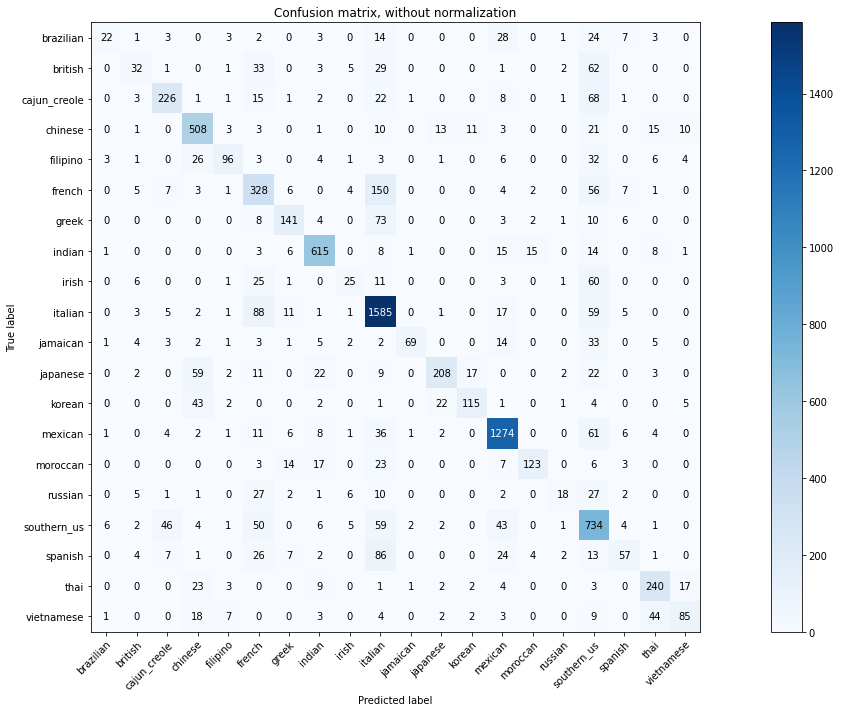

Epoch 1/50
652/652 [==============================] - 2s 3ms/step - loss: 1.4722 - accuracy: 0.5688
Epoch 2/50
652/652 [==============================] - 2s 3ms/step - loss: 1.0440 - accuracy: 0.6783
Epoch 3/50
652/652 [==============================] - 2s 3ms/step - loss: 0.9924 - accuracy: 0.6909
Epoch 4/50
652/652 [==============================] - 2s 3ms/step - loss: 0.9353 - accuracy: 0.7065
Epoch 5/50
652/652 [==============================] - 2s 3ms/step - loss: 0.9233 - accuracy: 0.7064
Epoch 6/50
652/652 [==============================] - 2s 3ms/step - loss: 0.9082 - accuracy: 0.7120
Epoch 7/50
652/652 [==============================] - 2s 3ms/step - loss: 0.9034 - accuracy: 0.7182
Epoch 8/50
652/652 [==============================] - 2s 3ms/step - loss: 0.8653 - accuracy: 0.7221
Epoch 9/50
652/652 [==============================] - 2s 3ms/step - loss: 0.8483 - accuracy: 0.7314
Epoch 10/50
652/652 [==============================] - 2s 3ms/step - loss: 0.8429 - accuracy: 0.7279

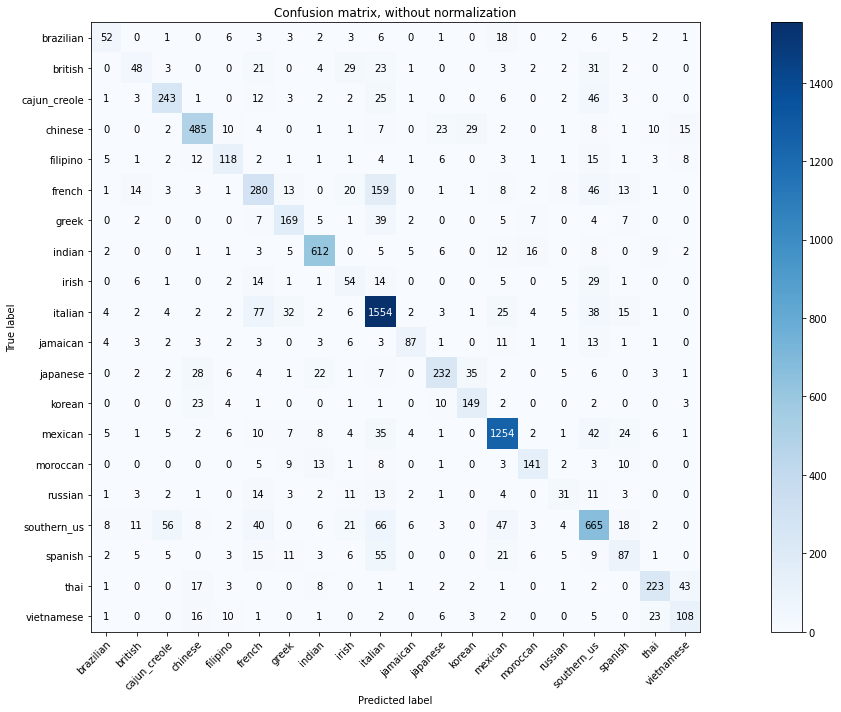

In [5]:
def hold_out(data, classes, model_type='svm', target_name=0, ratio=0.7, random_state=0):
    # Split Data
    y = data[target_name] # Target
    x = data.drop(target_name, axis=1) # Attribute
    train_x, valid_x, train_y, valid_y = train_test_split(x, y, train_size=ratio, random_state=random_state) # ratio = 7:3

    # train Model
    if model_type == 'svm':
        clf = sk.svm.SVC()
        clf.fit(train_x, train_y)
        # Predict
        pred = clf.predict(valid_x)
    elif model_type == 'ann' :
        clf = tf.keras.models.Sequential([
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(300, activation='sigmoid'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(600, activation='sigmoid'),
            tf.keras.layers.Dense(20, activation='sigmoid')
        ])

        clf.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

        clf.fit(train_x, train_y, epochs=50)
        # Predict
        pred = clf.predict(valid_x)
        pred = [np.argmax(d) for d in pred]

    # Display
    cl_labels = np.array(classes)

    print("|-----|-----|-----|-----|-----|")
    print("              %s              " % (model_type))
    print("|-----|-----|-----|-----|-----|")

    print(classification_report(valid_y, pred, target_names=cl_labels))
    plot_confusion_matrix(valid_y, pred, classes=cl_labels, cmap=plt.cm.Blues)
    plt.show()

hold_out(train_set, classes, 'svm')
hold_out(train_set, classes, 'ann')

## Without Word2Vec

In [6]:
train = pd.read_json('train.json')

enc = {}
enc_idx = 0

train_set_zp = []
for data in train.values.tolist():
    tmp = []
    tmp.append(data[1])
    for gre in data[2]:
        if gre in enc.keys():
            tmp.append(enc[gre])
        else:
            enc_idx+=1
            enc[gre] = enc_idx
            tmp.append(enc[gre])
    train_set_zp.append(tmp)
train_set_zp = pd.DataFrame(train_set_zp)

le = sk.preprocessing.LabelEncoder()
le.fit(train_set_zp[0])

classes = le.classes_

train_set_zp[0] = le.transform(train_set_zp[0])
train_set_zp = train_set_zp.fillna(0)
train_set_zp

0    1       2       3      4      5      6      7       8       9   \
0       9    1     2.0     3.0    4.0    5.0    6.0    7.0     8.0     9.0   
1      16   12    13.0    14.0   15.0   16.0   17.0   18.0    19.0    20.0   
2      18   22    23.0    24.0   25.0   26.0   27.0   28.0    29.0    30.0   
3      14    9    34.0    35.0   31.0   36.0   37.0   38.0     0.0     0.0   
4       3   30    39.0    40.0   11.0   41.0   42.0   26.0    43.0     0.0   
...    ..  ...     ...     ...    ...    ...    ...    ...     ...     ...   
29769  11   26   353.0    24.0  873.0   80.0   65.0  464.0   190.0  1153.0   
29770  19  471   775.0  2820.0  761.0  119.0  951.0   13.0  1916.0   771.0   
29771   7  191   210.0    50.0   43.0  190.0  168.0   13.0   101.0   626.0   
29772  16   15   218.0   489.0   18.0    0.0    0.0    0.0     0.0     0.0   
29773   3   41  1098.0    27.0   26.0  353.0  119.0   25.0  3246.0   187.0   

       ...   43   44   45   46   47   48   49   50   51   52  
0      ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1      ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2      ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3      ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4      ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  
29769  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
29770  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
29771  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
29772  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
29773  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[29774 rows x 53 columns]

|-----|-----|-----|-----|-----|
              svm              
|-----|-----|-----|-----|-----|
              precision    recall  f1-score   support

   brazilian       0.00      0.00      0.00       111
     british       0.00      0.00      0.00       169
cajun_creole       0.00      0.00      0.00       350
     chinese       0.00      0.00      0.00       599
    filipino       0.00      0.00      0.00       186
      french       0.07      0.00      0.01       574
       greek       0.00      0.00      0.00       248
      indian       0.16      0.01      0.02       687
       irish       0.00      0.00      0.00       133
     italian       0.21      0.88      0.34      1779
    jamaican       0.00      0.00      0.00       145
    japanese       0.00      0.00      0.00       357
      korean       0.00      0.00      0.00       196
     mexican       0.15      0.14      0.14      1418
    moroccan       0.00      0.00      0.00       196
     russian       0.00      0.00      

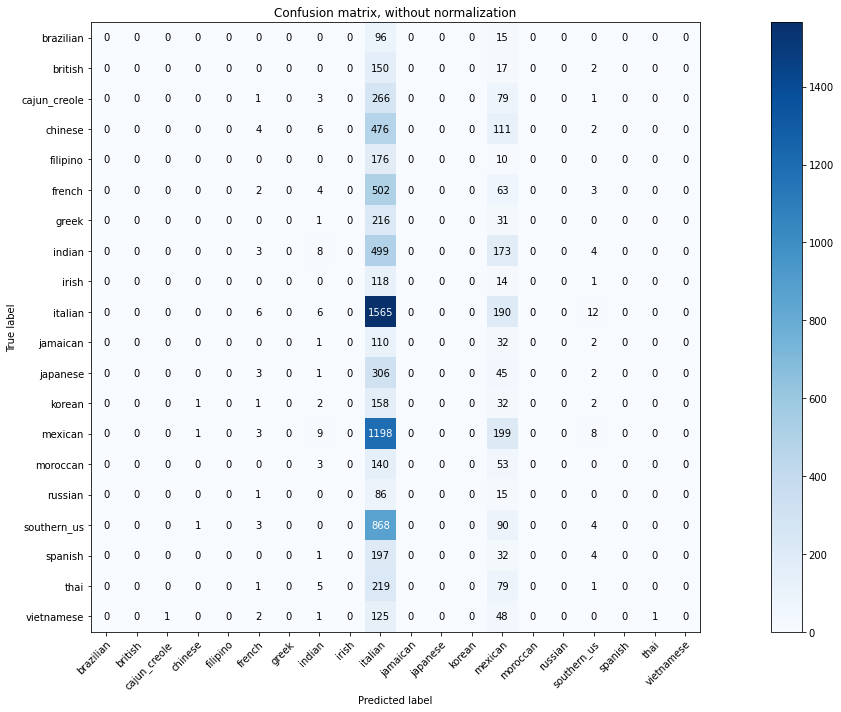

Epoch 1/50
652/652 [==============================] - 2s 3ms/step - loss: 2.6642 - accuracy: 0.1856
Epoch 2/50
652/652 [==============================] - 2s 3ms/step - loss: 2.5937 - accuracy: 0.1955
Epoch 3/50
652/652 [==============================] - 2s 3ms/step - loss: 2.5741 - accuracy: 0.2106
Epoch 4/50
652/652 [==============================] - 2s 3ms/step - loss: 2.5756 - accuracy: 0.2043
Epoch 5/50
652/652 [==============================] - 2s 3ms/step - loss: 2.5684 - accuracy: 0.2093
Epoch 6/50
652/652 [==============================] - 2s 4ms/step - loss: 2.5686 - accuracy: 0.2099
Epoch 7/50
652/652 [==============================] - 2s 4ms/step - loss: 2.5703 - accuracy: 0.2075
Epoch 8/50
652/652 [==============================] - 2s 3ms/step - loss: 2.5652 - accuracy: 0.2073
Epoch 9/50
652/652 [==============================] - 2s 3ms/step - loss: 2.5734 - accuracy: 0.2076
Epoch 10/50
652/652 [==============================] - 2s 3ms/step - loss: 2.5589 - accuracy: 0.2071

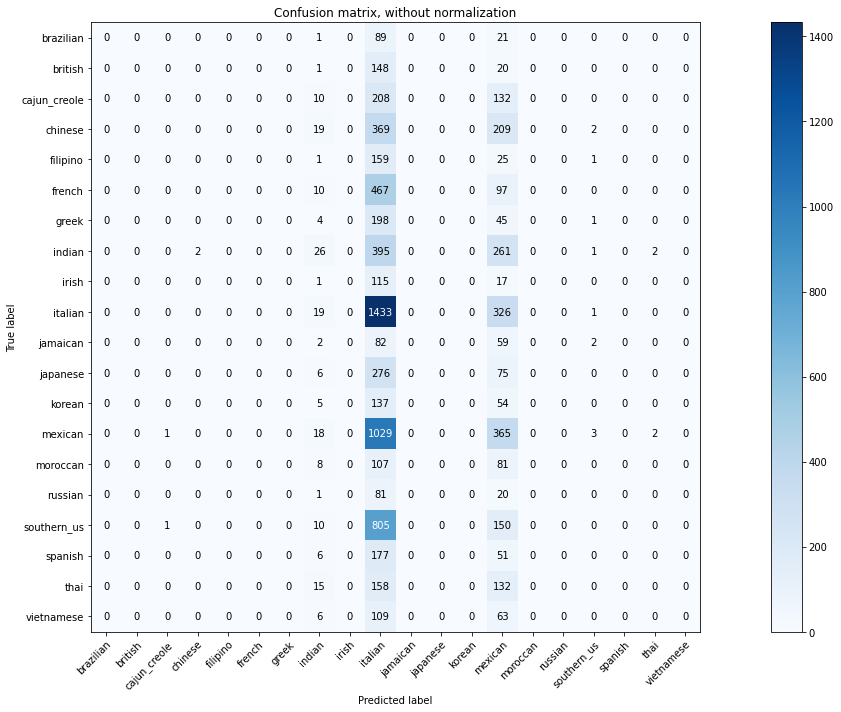

In [7]:
hold_out(train_set_zp, classes, 'svm')
hold_out(train_set_zp, classes, 'ann')

# Kaggle

In [8]:
train = pd.read_json('train.json')
train_set = []
for data in train.values.tolist():
    tmp = []
    tmp.append(data[1])
    gre_vec = np.array([0 for _ in range(300)])
    for gre in data[2]:
        gre_vec = np.add(gre_vec, np.array(model.wv[gre]))
    tmp.extend(gre_vec)
    train_set.append(tmp)
train_set = pd.DataFrame(train_set)

le = sk.preprocessing.LabelEncoder()
le.fit(train_set[0])

classes = le.classes_

train_set[0] = le.transform(train_set[0])
train_set

0         1         2         3         4         5         6    \
0        9 -2.044709 -4.018720  2.395507  2.439996 -2.279481  2.327987   
1       16 -3.879736  0.265346  0.435484 -0.133509 -1.777257  2.486038   
2       18  3.866721 -2.406342  3.019859  5.592268  0.576502  4.849381   
3       14  0.207400  0.836980 -0.702978 -0.347707  0.654110  0.182332   
4        3 -0.184935 -3.036445  2.845268  3.397919  0.532851  0.644099   
...    ...       ...       ...       ...       ...       ...       ...   
29769   11  1.993824 -5.791325  5.969348  5.675846 -0.149109  4.830204   
29770   19  2.237145 -2.707862  2.700255  4.002712  3.238416  1.782970   
29771    7  2.633150 -5.685830 -1.538185  4.532124  1.670512  3.064936   
29772   16 -2.035557  1.711829 -0.099580 -2.230456 -0.723709 -0.277013   
29773    3  3.075139 -2.036712  4.780722  5.802364  0.977730  4.108366   

            7         8         9    ...       291       292       293  \
0     -1.674883 -0.711110  2.885326  ... -0.666904 -0.739586  0.136757   
1     -1.653275 -1.984970  4.923468  ...  0.040015 -2.655413  3.117069   
2     -0.381780  2.709098 -2.496708  ... -0.340766  0.129807 -3.997205   
3      1.377733  1.137936 -0.691391  ...  0.391705 -1.536112 -0.643965   
4      0.190870  1.763180 -1.015252  ... -0.327670 -0.732443 -2.100808   
...         ...       ...       ...  ...       ...       ...       ...   
29769 -2.743736 -0.343443 -0.649310  ... -2.953662 -0.726731 -1.623594   
29770  0.511791 -1.715388 -1.467139  ... -0.686781 -1.548297  0.847894   
29771 -1.591673  0.926298 -1.784572  ... -2.211229  5.012066 -2.601474   
29772 -0.998270 -0.274748  1.426483  ...  0.165403 -1.254661  1.507896   
29773 -0.172233  0.707145 -5.220014  ... -2.030691  0.402347 -3.008554   

            294       295       296       297       298       299       300  
0      3.667833  1.006391  0.747489 -0.833672  1.878203  4.308890 -1.959233  
1     -1.071181 -3.415086 -3.000370  0.034450 -3.451481 -1.027403  0.179197  
2     -7.277786  0.355280  5.100685 -2.579321 -1.388892  0.091360  0.045063  
3     -0.212960  1.113605  0.556294 -1.116117  0.981529 -1.366012  1.076151  
4     -1.619149  1.222839  1.755704 -1.453044  1.177404  0.275419 -0.504934  
...         ...       ...       ...       ...       ...       ...       ...  
29769 -7.333714  5.997478  4.033377 -0.183722  1.551796  7.278427  0.575252  
29770 -2.926321  2.679469  0.496765 -2.669453  2.532807  0.896127  0.546791  
29771 -6.983623  4.106723  0.784380  3.246407 -2.627756  5.223648 -4.568245  
29772  1.656836 -0.523382 -3.023871 -0.706958 -1.061364 -0.827929 -0.906743  
29773 -5.420252  3.155465  4.499257 -2.148232  2.048544  3.531500  2.594180  

[29774 rows x 301 columns]

In [9]:
test = pd.read_json('test.json')
test_set = []
for data in test.values.tolist():
    tmp = []
    gre_vec = np.array([0 for _ in range(300)])
    for gre in data[1]:
        gre_vec = np.add(gre_vec, np.array(model.wv[gre]))
    tmp.extend(gre_vec)
    test_set.append(tmp)
test_set = pd.DataFrame(test_set)
test_set

0         1         2         3         4         5         6    \
0    -1.209068 -1.917743  1.318054 -1.964441  0.202945  1.164149  1.150160   
1    -3.976359 -9.012816  6.247386  5.996047 -2.461929  7.002187 -4.066643   
2     0.550982 -4.860235  2.789350  1.144319  1.369842  1.017969 -1.441407   
3     0.788950 -5.695171 -0.256753  7.389452  2.639896 -4.761248  4.530795   
4    -1.365689 -2.563351  0.184788  2.583661  4.582117  1.696867  2.738909   
...        ...       ...       ...       ...       ...       ...       ...   
9995 -4.193210 -7.506216  2.082035  5.770354 -2.726627  4.802542 -4.028894   
9996 -0.000870 -1.059073  2.654029  0.626837  1.373221  1.852456  0.201373   
9997 -0.573449 -0.071325  0.650780 -0.459193  0.500933  0.912653 -0.033403   
9998 -2.000483 -0.441512  1.475983 -1.983283  0.473390 -0.279834 -2.731084   
9999  0.379884 -1.583119  2.724367  3.119716 -2.379118  3.404583 -2.124218   

           7         8         9    ...       290       291       292  \
0     0.859135  1.827828  0.751736  ...  0.351677 -0.280243 -0.372324   
1    -7.017736  6.355549  1.825303  ... -2.532355  5.498765  0.033684   
2    -0.686081  4.202579  3.313294  ...  0.652406  0.755521 -0.291399   
3     5.850284  5.269200 -2.591048  ...  1.438139  3.499220 -7.607122   
4     2.443467  5.130060  0.130793  ...  3.280253 -0.205387 -0.519558   
...        ...       ...       ...  ...       ...       ...       ...   
9995 -5.291611  4.072767  0.897433  ... -7.317013  4.422419 -1.824605   
9996  1.281348 -0.274600  1.211359  ...  1.277324 -2.848850 -0.599165   
9997  0.442237  0.676431  0.136362  ...  0.174649 -1.653166  0.092441   
9998 -0.512056  1.221360 -0.408490  ... -1.664517 -0.629502  3.062983   
9999 -6.336764 -0.762954 -0.880602  ... -2.421618  2.964302  0.865411   

           293       294       295       296       297       298       299  
0    -1.968153  1.362479  0.086298 -0.968822 -2.175677  1.157705  0.534604  
1    -4.189129  3.474219 -1.803447  4.577782 -3.270904  3.893417 -3.233312  
2    -0.598925  1.186277 -1.566164  0.784886 -0.801859  0.496124 -2.826743  
3    -9.011278  0.449967 -2.641710  1.346964 -2.372790 -3.252054 -0.434903  
4    -2.889008 -0.263554 -0.406984  1.755171 -0.791931 -3.195536 -0.066503  
...        ...       ...       ...       ...       ...       ...       ...  
9995 -3.375481  6.725847  3.361071  6.148783  2.046419  5.773408 -6.318504  
9996  1.020281 -0.738707 -0.010966 -2.187426  1.319006  1.541193  0.141365  
9997  0.077889  0.059612  0.203616 -0.143868  0.550099  0.336076  0.850446  
9998 -4.362239 -0.593624 -1.071119 -0.703100 -1.219891  3.375097 -0.990192  
9999 -0.807214  4.515320 -2.776164  5.490889 -1.763995  4.445413 -4.538908  

[10000 rows x 300 columns]

In [10]:
def kaggle(data, target_name=0):
    # Split Data
    train_y = data[target_name] # Target
    train_x = data.drop(target_name, axis=1) # Attribute

    # train Model
    clf = tf.keras.models.Sequential([
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(300, activation='sigmoid'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(600, activation='sigmoid'),
            tf.keras.layers.Dense(20, activation='sigmoid')
        ])

    clf.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

    clf.fit(train_x, train_y, epochs=50)
       

    return clf

clf = kaggle(train_set)

Epoch 1/50
931/931 [==============================] - 3s 3ms/step - loss: 1.3903 - accuracy: 0.5918
Epoch 2/50
931/931 [==============================] - 3s 3ms/step - loss: 0.9964 - accuracy: 0.6896
Epoch 3/50
931/931 [==============================] - 3s 3ms/step - loss: 0.9608 - accuracy: 0.7005
Epoch 4/50
931/931 [==============================] - 3s 3ms/step - loss: 0.9465 - accuracy: 0.7042
Epoch 5/50
931/931 [==============================] - 3s 3ms/step - loss: 0.9113 - accuracy: 0.7167
Epoch 6/50
931/931 [==============================] - 3s 3ms/step - loss: 0.9020 - accuracy: 0.7139
Epoch 7/50
931/931 [==============================] - 3s 3ms/step - loss: 0.8746 - accuracy: 0.7227
Epoch 8/50
931/931 [==============================] - 3s 3ms/step - loss: 0.8623 - accuracy: 0.7283
Epoch 9/50
931/931 [==============================] - 3s 3ms/step - loss: 0.8487 - accuracy: 0.7306
Epoch 10/50
931/931 [==============================] - 3s 3ms/step - loss: 0.8353 - accuracy: 0.7346

In [11]:
pred = clf.predict(test_set)
pred = [np.argmax(d) for d in pred]

pred_cate = [classes[idx] for idx in pred]
id_list = [data[0] for data in test.values.tolist()]

import csv
with open('pred.csv', 'w') as csv_file:
    writer = csv.writer(csv_file)

    writer.writerow(['Id', 'Category'])

    idx = 0
    for id in id_list:
        writer.writerow([id, pred_cate[idx]])
        idx+=1

    
